## 1. Import library

In [18]:
import os
import re
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score
)
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_colwidth", 120)
RANDOM_STATE = 42

## 2. Read Data

In [19]:
DATA_PATH = "../data/Tweets.csv"

if DATA_PATH is None:
    raise FileNotFoundError(
        "Không tìm thấy file Tweets.csv. Hãy mở panel 'Add data' và kiểm tra đường dẫn.\n"
        "Ví dụ: /kaggle/input/tweets/Tweets.csv"
    )

df = pd.read_csv(DATA_PATH)
print("Đã đọc dữ liệu:", DATA_PATH)
print("thông tin dữ liệu")
df.info()

Đã đọc dữ liệu: ../data/Tweets.csv
thông tin dữ liệu
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  float64
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_c

## 3. EDA CƠ BẢN: PHÂN BỐ SENTIMENT

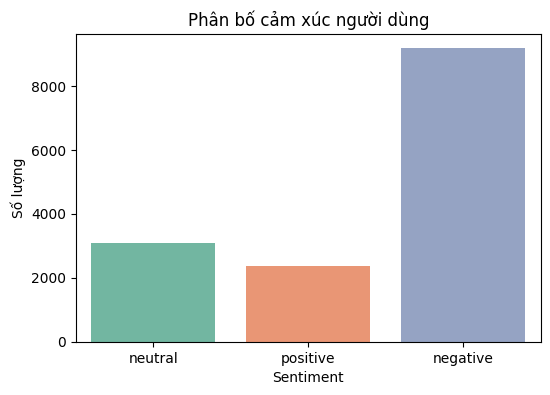

Số lượng theo sentiment:
 airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [20]:
plt.figure(figsize=(6,4))
sns.countplot(
    x="airline_sentiment",
    hue="airline_sentiment",  
    data=df,
    palette="Set2",
    legend=False              
)
plt.title("Phân bố cảm xúc người dùng")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng")
plt.show()

print("Số lượng theo sentiment:\n", df["airline_sentiment"].value_counts())

## 4. LÀM SẠCH TEXT → cột clean_text

In [21]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)       # bỏ URL
    text = re.sub(r"@\w+", " ", text)          # bỏ mention
    text = re.sub(r"#", " ", text)             # bỏ dấu #
    text = re.sub(r"[^a-z\s]", " ", text)      # bỏ ký tự không phải chữ
    text = re.sub(r"\s+", " ", text).strip()   # bỏ khoảng trắng dư
    return text

df["text"] = df["text"].fillna("")
df["clean_text"] = df["text"].apply(clean_text)
df[["text","clean_text"]].head(5)

,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,plus you ve added commercials to the experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,i didn t today must mean i need to take another trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have littl...",it s really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
4,@VirginAmerica and it's a really big bad thing about it,and it s a really big bad thing about it


## 5. WORDCLOUD CHO MỖI SENTIMENT

In [ ]:
for sentiment in df["airline_sentiment"].unique():
    text_blob = " ".join(df.loc[df["airline_sentiment"]==sentiment, "clean_text"])
    if len(text_blob) < 10:  # tránh lỗi với nhóm quá ít
        continue
    plt.figure(figsize=(7,4))
    wc = WordCloud(width=900, height=400, background_color="white").generate(text_blob)
    plt.imshow(wc, interpolation="bilinear"); plt.axis("off")
    plt.title(f"WordCloud – {sentiment}")
    plt.show()

## 6. Phân tích mở rộng
### 6.1 Sentiment theo từng hãng hàng không

In [ ]:
plt.figure(figsize=(10,6))
sentiment_by_airline = df.groupby(["airline","airline_sentiment"]).size().unstack(fill_value=0)
sentiment_by_airline.plot(kind="bar", stacked=True, figsize=(10,6), colormap="coolwarm")
plt.title("Tỷ lệ sentiment theo hãng hàng không")
plt.ylabel("Số lượng tweet"); plt.xlabel("Hãng hàng không")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

### 6.2 Sentiment theo giờ đăng tweet

In [ ]:
if "tweet_created" in df.columns:
    df["tweet_created"] = pd.to_datetime(df["tweet_created"], errors="coerce")
    df["hour"] = df["tweet_created"].dt.hour
    
    plt.figure(figsize=(12,5))
    sns.countplot(
        x="hour",
        hue="airline_sentiment",
        data=df,
        palette="Set2"
    )
    
    plt.title("Cảm xúc theo giờ đăng tweet")
    plt.xlabel("Giờ (0–23)")
    plt.ylabel("Số lượng tweet")
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

### 6.3 Top múi giờ

In [ ]:
if "user_timezone" in df.columns:
    top_tz = df["user_timezone"].value_counts().head(10)
    if len(top_tz) > 0:
        plt.figure(figsize=(9,4))
        sns.barplot(x=top_tz.values, y=top_tz.index, palette="viridis")
        plt.title("Top 10 múi giờ của người dùng")
        plt.xlabel("Số lượng"); plt.ylabel("Múi giờ")
        plt.tight_layout(); plt.show()

### 6.4 Lý do tiêu cực (negativereason)

In [ ]:
if "negativereason" in df.columns:
    neg_reason = df["negativereason"].value_counts().head(12)
    if len(neg_reason) > 0:
        plt.figure(figsize=(9,5))
        sns.barplot(y=neg_reason.index, x=neg_reason.values, palette="Reds_r")
        plt.title("Top lý do người dùng phàn nàn (negative)")
        plt.xlabel("Số lượng tweet"); plt.ylabel("Lý do")
        plt.tight_layout(); plt.show()

### 6.5 Độ dài tweet theo sentiment

In [ ]:
df["text_length"] = df["clean_text"].apply(lambda s: len(s.split()))
plt.figure(figsize=(7,5))
sns.boxplot(x="airline_sentiment", y="text_length", data=df, palette="Set2")
plt.title("Phân bố độ dài tweet theo cảm xúc")
plt.xlabel("Sentiment"); plt.ylabel("Số từ")
plt.tight_layout(); plt.show()

## 7. TF-IDF + CHIA TẬP TRAIN/TEST

In [ ]:
X_text = df["clean_text"]
y = df["airline_sentiment"]

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

## 8. HUẤN LUYỆN & SO SÁNH NHIỀU MÔ HÌNH
###   - Naive Bayes
###  - Logistic Regression
###    - Linear SVM

In [ ]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=None),
    "Linear SVM": LinearSVC()
}

results = []
for name, clf in models.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = round(accuracy_score(y_test, pred), 4)
    results.append((name, acc))
    print(f"\n================= {name} =================")
    print("Accuracy:", acc)
    print(classification_report(y_test, pred))

### 8.1 Bảng so sánh

In [ ]:
res_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values("Accuracy", ascending=False)
print("\n📊 So sánh Accuracy:")
print(res_df)

### 8.2 Chọn model tốt nhất để vẽ Confusion Matrix

In [ ]:
best_model_name = res_df.iloc[0]["Model"]
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

## 9. TOP TỪ KHÓA TF-IDF THEO TỪNG SENTIMENT

In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())

def top_tfidf_words(text_series, top_k=12):
    # fit riêng trên subset để lấy trọng số trung bình theo nhóm
    X_grp = tfidf.fit_transform(text_series)
    means = np.asarray(X_grp.mean(axis=0)).flatten()
    idx = means.argsort()[-top_k:][::-1]
    return feature_names[idx]

for sentiment in ["positive", "negative", "neutral"]:
    subset = df[df["airline_sentiment"] == sentiment]["clean_text"]
    if len(subset) < 5:
        continue
    words = top_tfidf_words(subset, top_k=12)
    print(f"\n🔹 Top TF-IDF words – {sentiment}:")
    print(", ".join(words))

## 10. PCA 2D (trực quan hoá không gian vector – demo)

In [ ]:
SAMPLE_FOR_PCA = min(3000, X_tfidf.shape[0])
idx_sample = np.random.RandomState(RANDOM_STATE).choice(X_tfidf.shape[0], SAMPLE_FOR_PCA, replace=False)
X_sample = X_tfidf[idx_sample].toarray()
y_sample = y.iloc[idx_sample].values

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_sample)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y_sample, alpha=0.5, s=25, palette="Set2")
plt.title("Biểu diễn PCA 2D của tweet theo sentiment")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(); plt.show()

## 11. THỬ DỰ ĐOÁN TWEET MỚI

In [ ]:
sample_tweets = [
    "The flight was delayed for 3 hours, terrible experience.",
    "Amazing service! The crew was so kind and helpful.",
    "It was okay, nothing special.",
    "Customer service solved my issue quickly, thanks!"
]
# Dùng tfidf đã fit trên tập đầy đủ (X_text)
tfidf_full = TfidfVectorizer(max_features=5000, stop_words="english")
X_full = tfidf_full.fit_transform(X_text)
# Train lại best model trên toàn bộ dữ liệu để dự đoán mẫu (optional)
best_model.fit(X_full, y)

sample_vec = tfidf_full.transform(sample_tweets)
sample_pred = best_model.predict(sample_vec)
print("\n Dự đoán ví dụ:")
for t, p in zip(sample_tweets, sample_pred):
    print(f"- {t}  →  {p}")

## 12.  KẾT LUẬN TÓM TẮT

In [ ]:
summary = {
    "Best Model": best_model_name,
    "Best Accuracy": float(res_df.iloc[0]["Accuracy"]),
    "Negative Ratio": float((df["airline_sentiment"]=="negative").mean()),
    "Mean Tweet Length": float(df["text_length"].mean())
}
print("\n===== SUMMARY (copy vào báo cáo) =====")
for k,v in summary.items():
    print(f"{k}: {v}")
print("Gợi ý insight: Negative chiếm tỷ lệ lớn; lý do top thường là 'Late Flight', 'Customer Service Issue';"
      " hãng A/B có tỷ lệ negative cao; tweet negative thường dài hơn.")